In [49]:
from iads.data_traitement import traitement
from iads.nlp import preprocessing

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# I. Chargement des données :

In [2]:
df_jeux_up = pd.read_csv("../data/details_clean.csv")

# II. Clustering des catégories d'un jeu :

L'attribut `categories` d'un jeu est une suite de catégories séparées par des '|'

In [3]:
jeux_cat = df_jeux_up.apply(traitement.extract_categories, axis=1)

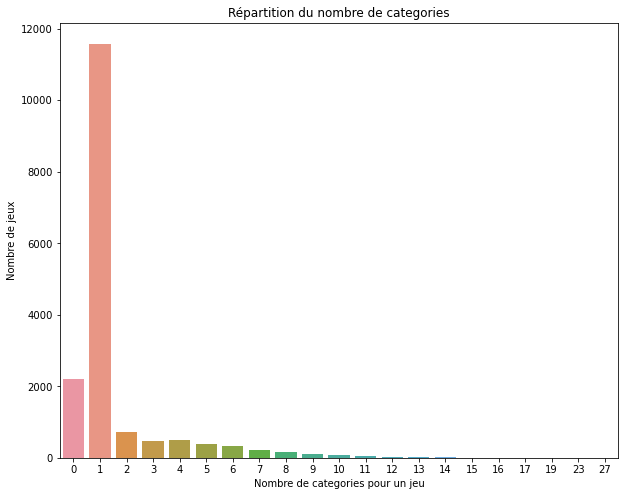

In [4]:
val, count = np.unique(jeux_cat.map(len), return_counts=True)
index = count.argsort()[::-1]
count = count[index]
val = val[index]

plt.figure(figsize=(10, 8))
sns.barplot(x = val, y = count)
plt.xlabel("Nombre de categories pour un jeu")
plt.ylabel("Nombre de jeux")
plt.title("Répartition du nombre de categories")
plt.show()

In [5]:
count[val == 0].sum() / len(jeux_cat)

0.13026729093818526

In [6]:
count[val == 1].sum() / len(jeux_cat)

0.6863628281870444

In [7]:
count[val > 1].sum() / len(jeux_cat)

0.18336988087477035

- Les majorités des jeux ont qu'une seule catégorie (68% des jeux), et environ 13% de jeux n'ont pas de catégories. 
- 18% ont plus d'une catégorie.

Avoir plusieurs catégories pour un jeu peut être dérangeant, pour des problèmes de classification entre autres.

In [8]:
cats = []
jeux_cat.map(cats.extend)
u_cats, count_cats = np.unique(cats, return_counts=True)

index      = count_cats.argsort()[::-1]
count_cats = count_cats[index]
u_cats     = u_cats[index]

In [9]:
print(f"{len(u_cats)} tag de categories")

184 tag de categories


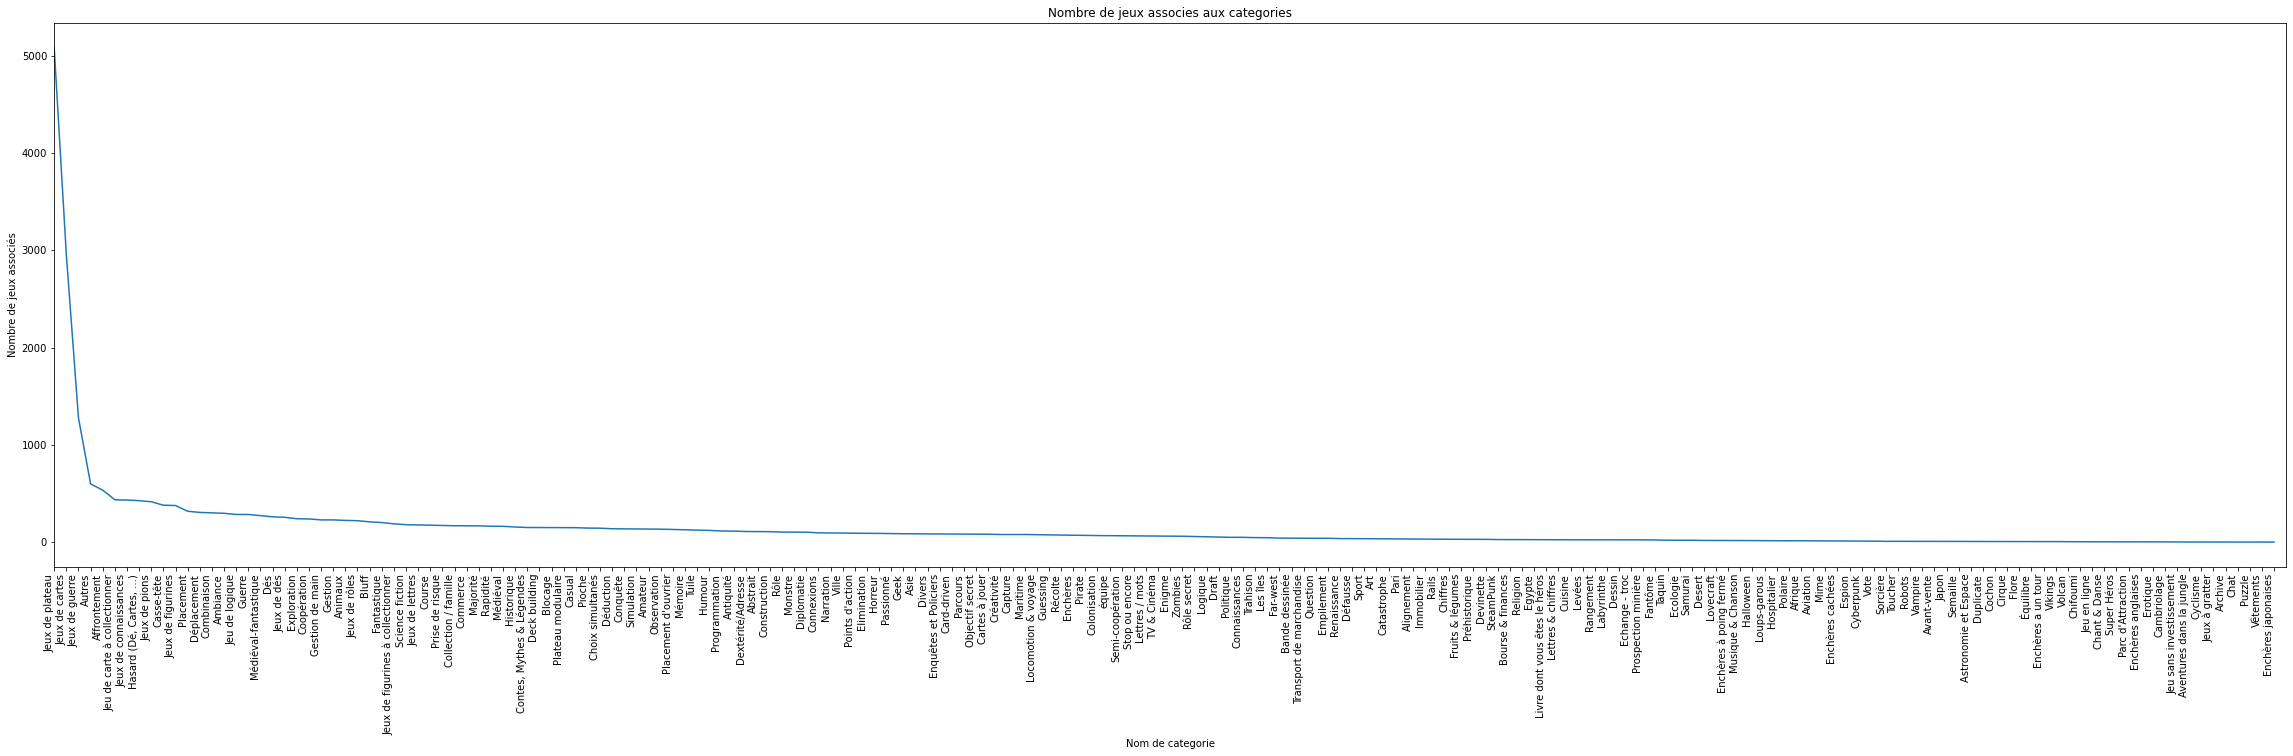

In [10]:
plt.figure(figsize=(40, 10))
plt.plot(u_cats, count_cats)
plt.xticks(rotation=90, ha='right')
plt.xlabel("Nom de categorie")
plt.ylabel("Nombre de jeux associés")
plt.title("Nombre de jeux associes aux categories")
plt.xlim((0, len(u_cats)))
plt.show()

### 1. Nettoyer les catégories : 

In [11]:
# Installer les ressources nécessaires

# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

# import spacy
# spacy.cli.download("fr_core_news_lg")

On nettoie les catégories en supprimant les ponctuations, caractères spéciaux, les stops word ....

In [12]:
c_cats = []

for cat in u_cats:
    cat_ = preprocessing.clean_text(cat)
    cat_tokens = preprocessing.tokenize_text(cat_)    
    cat_tokens = preprocessing.remove_stopwords(cat_tokens)
    cat_tokens = preprocessing.lemmatize_tokens(cat_tokens)
    cat_ = " ".join(cat_tokens)
    c_cats.append(cat_)

#### Mise à jour des categories des jeux

Remplacer les catégories par leur version nettoyée

In [13]:
jeux_cat_up = jeux_cat.copy()

for i, row in jeux_cat.iteritems():
    row_ = []
    
    for cat in row:
        index = np.where(u_cats == cat)[0][0]
        row_.append(c_cats[index])
        
    jeux_cat_up[i] = np.unique(row_)
    
jeux_cat_up.head()

0                                                   []
1                                                   []
2    [aventure jungle, collection famille, enchere,...
3                                                   []
4    [card driven, combinaison, cooperation, deck b...
dtype: object

#### Suppression de la catégorie `autre` :

In [14]:
print("Nombre de jeux ayant autre comme catégorie :", np.where(jeux_cat_up.map(lambda l : "autre" in l), 1, 0).sum())

Nombre de jeux ayant autre comme catégorie : 599


In [15]:
jeux_cat_up = jeux_cat_up.map(lambda l : np.array(list(filter(("autre").__ne__, l))))
jeux_cat_up = jeux_cat_up.map(lambda l : np.array(list(filter(("").__ne__, l))))

In [16]:
print("Nombre de jeux ayant autre comme catégorie :", np.where(jeux_cat_up.map(lambda l : "autre" in l), 1, 0).sum())

Nombre de jeux ayant autre comme catégorie : 0


In [17]:
cats = []
jeux_cat_up.map(cats.extend)

uc_cats, count_cats = np.unique(cats, return_counts=True)

index      = count_cats.argsort()[::-1]
count_cats = count_cats[index]
uc_cats    = uc_cats[index]

In [18]:
print(f"Apres nettoyage on a {len(uc_cats)} tag de categorie")

Apres nettoyage on a 172 tag de categorie


### 2. Clustering des categories : 

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(uc_cats)
n_clusters = 155

On lance un clustering `kmeans` sur les catégories pour réaliser un clustering syntaxique (mots en commun entre les catégories)

In [20]:
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", random_state=0)
kmeans.fit(X)

for i in range(n_clusters):
    print(f"Cluster {i}:")
    for category in np.array(uc_cats)[kmeans.labels_ == i]:
        print(f"\t{category}")

Cluster 0:
	transport marchandise
	puzzle
Cluster 1:
	carte
	dé
	hasard dé carte
Cluster 2:
	fantome
Cluster 3:
	gestion
	gestion main
Cluster 4:
	cambriolage
Cluster 5:
	enchere
	enchere poing ferme
	enchere cachee
	enchere tour
	enchere anglais
	enchere japonais
Cluster 6:
	placement
	placement ouvrier
Cluster 7:
	chiffre
	lettre chiffre
Cluster 8:
	plateau
	plateau modulaire
Cluster 9:
	parc attraction
Cluster 10:
	dessin
Cluster 11:
	devinette
Cluster 12:
	sorciere
Cluster 13:
	exploration
Cluster 14:
	enquete policier
Cluster 15:
	erotiqu
Cluster 16:
	horreur
Cluster 17:
	livre hero
	super hero
Cluster 18:
	parcours
Cluster 19:
	question
Cluster 20:
	role
Cluster 21:
	vetement
Cluster 22:
	loup garou
Cluster 23:
	medieval fantastique
	fantastique
	medieval
Cluster 24:
	conte mythe legende
Cluster 25:
	cyclisme
Cluster 26:
	lettre
	lettre mot
Cluster 27:
	equipe
Cluster 28:
	steampunk
Cluster 29:
	mime
Cluster 30:
	bluff
Cluster 31:
	diplomati
Cluster 32:
	historique
Cluster 33:
	r

Donner un nom pour chaque cluster de catégories, tel que le cluster i aura comme nom la concatenation des mots les plus fréquents dans les noms des catégories qui appartiennent à ce dernier.

In [21]:
name_clust = []

for i in range(n_clusters):
    L_clus = []
    
    for category in np.array(uc_cats)[kmeans.labels_ == i]:
        L_clus.extend(category.split(" "))

    noms, counts = np.unique(np.array(L_clus), return_counts=True)
    
    index  = counts.argsort()[::-1]
    counts = counts[index]
    noms   = noms[index]   
    
    name_clust.append(" ".join(noms[counts == counts[0]]))
    
print(name_clust)

['transport puzzle marchandise', 'dé carte', 'fantome', 'gestion', 'cambriolage', 'enchere', 'placement', 'chiffre', 'plateau', 'parc attraction', 'dessin', 'devinette', 'sorciere', 'exploration', 'policier enquete', 'erotiqu', 'horreur', 'hero', 'parcours', 'question', 'role', 'vetement', 'loup garou', 'medieval fantastique', 'mythe legende conte', 'cyclisme', 'lettre', 'equipe', 'steampunk', 'mime', 'bluff', 'diplomati', 'historique', 'rangement', 'logique', 'afrique', 'defausse', 'chat', 'programmation', 'deck building', 'vote', 'taquin', 'dexterite adresse', 'rapidite', 'duplicate', 'animal', 'ville', 'deduction', 'conquete', 'simulation', 'passionner', 'guessing', 'famille collection', 'connexion', 'monstre', 'geek', 'driven card', 'objectif', 'tete casser', 'pirate', 'affrontement', 'tuile', 'pion', 'maritime', 'casual', 'cooperation', 'halloween', 'memoire', 'cochon', 'combinaison', 'immobilier', 'religion', 'aviation', 'volcan', 'vampire', 'chifoumi', 'observation', 'zombie', '

Change les nom des catégories des jeux par le nom de leur cluster

In [22]:
jeux_cat_up_gen = jeux_cat_up.copy()

for i in range(n_clusters):
    cat_clus_i = np.array(uc_cats)[kmeans.labels_ == i]
    jeux_cat_up_gen = jeux_cat_up_gen.map(lambda l : [name_clust[i] if x in cat_clus_i else x for x in l])

In [23]:
cats_gen = []
jeux_cat_up_gen.map(cats_gen.extend)

uc_cats_gen, count_cats = np.unique(cats_gen, return_counts=True)

index       = count_cats.argsort()[::-1]
uc_cats_gen = uc_cats_gen[index]
count_cats  = count_cats[index]

In [24]:
print(f"Après clustering on a {len(uc_cats_gen)} categories")

Après clustering on a 155 categories


### 3. Sélection des N catégories principales : 

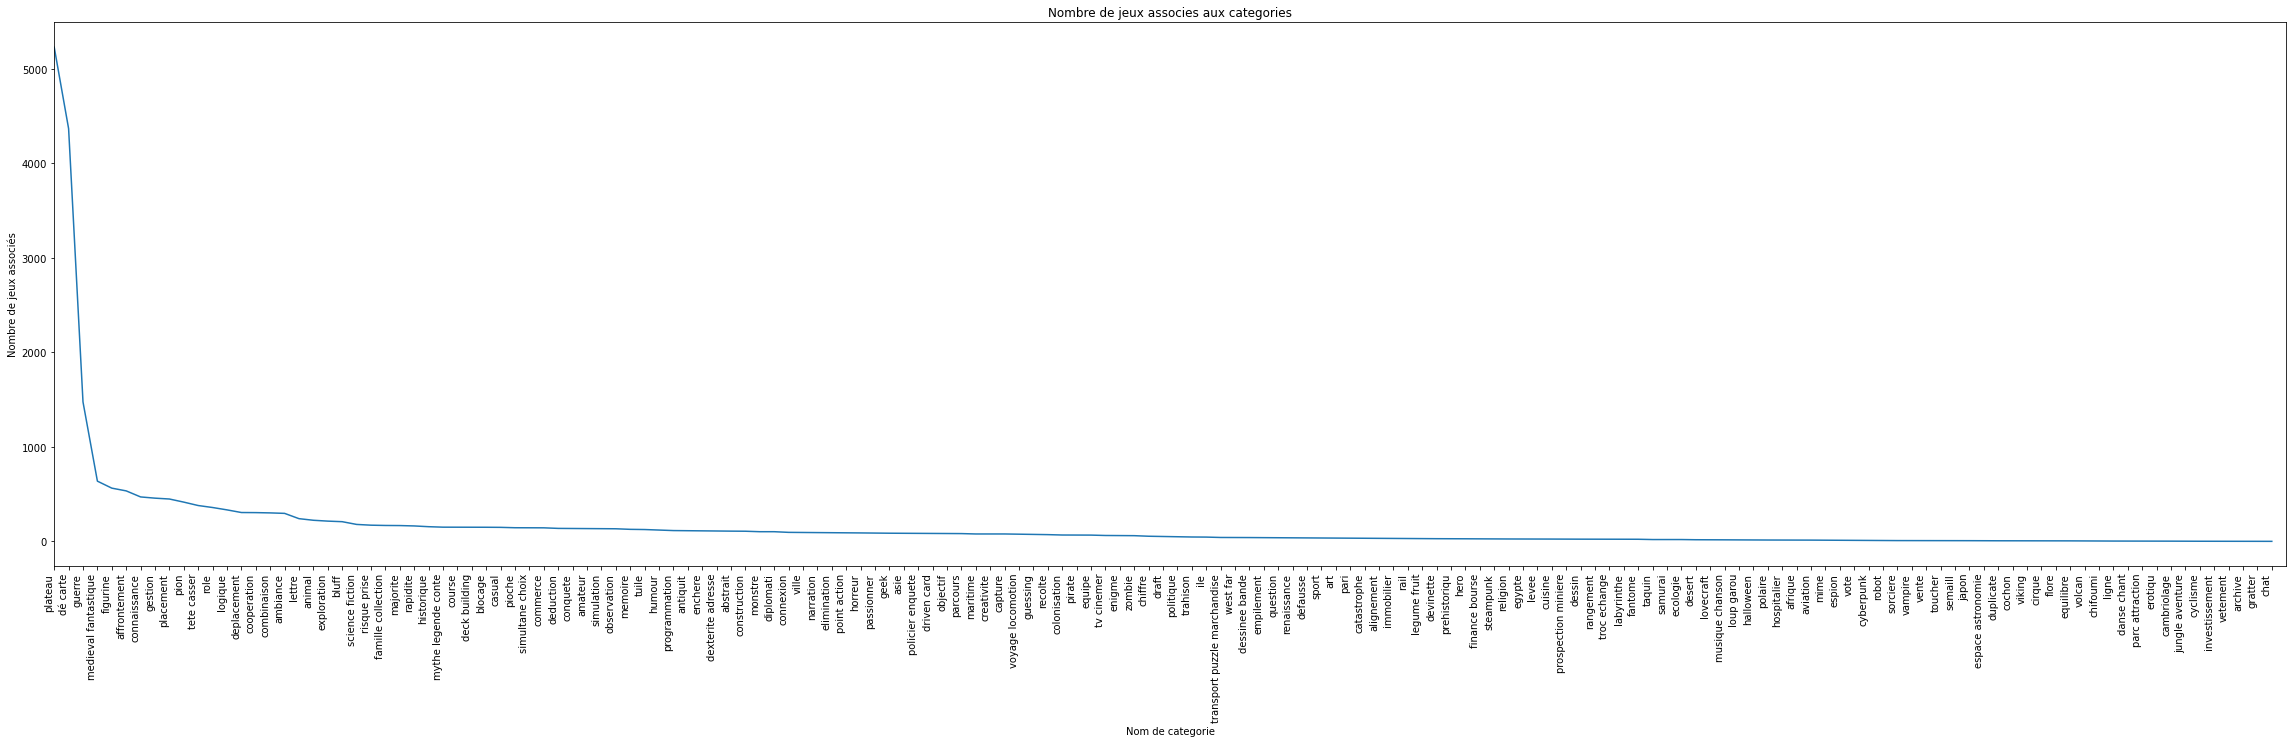

In [25]:
plt.figure(figsize=(40, 10))
plt.plot(uc_cats_gen, count_cats)
plt.xticks(rotation=90, ha='right')
plt.xlabel("Nom de categorie")
plt.ylabel("Nombre de jeux associés")
plt.title("Nombre de jeux associes aux categories")
plt.xlim((0, len(uc_cats_gen)))
plt.show()

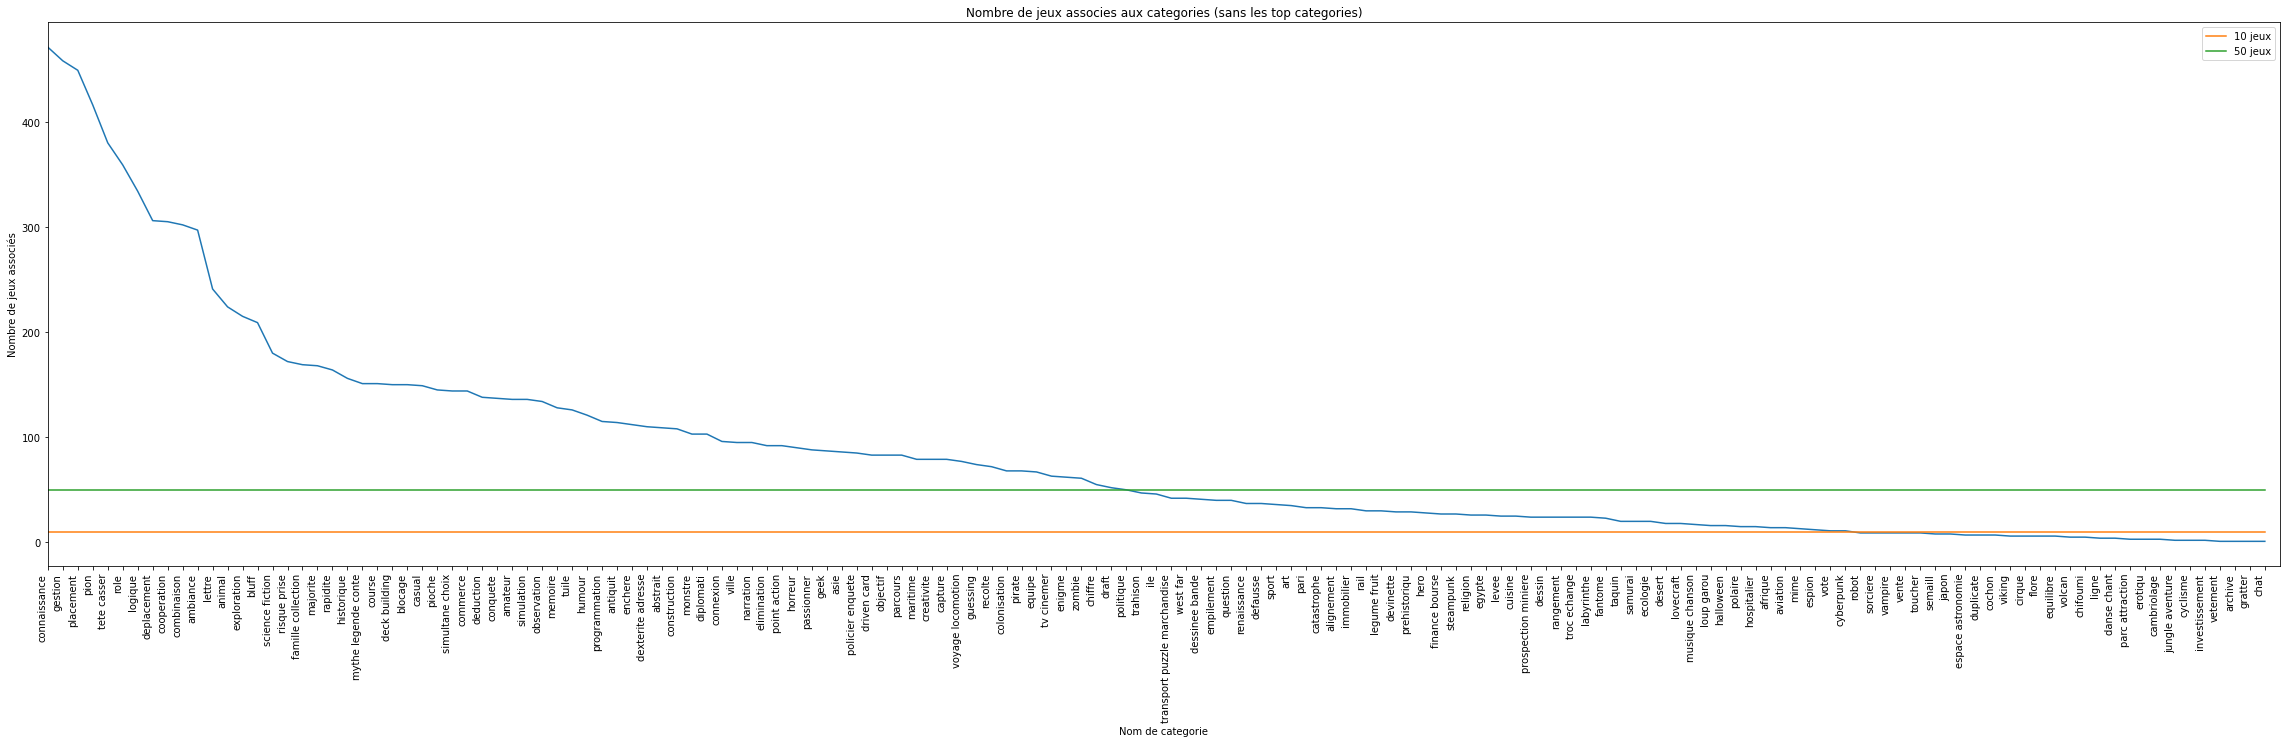

In [26]:
index = count_cats < 500
plt.figure(figsize=(40, 10))
plt.plot(uc_cats_gen[index], count_cats[index])
plt.plot(np.full(len(uc_cats_gen[index]), 10), label="10 jeux")
plt.plot(np.full(len(uc_cats_gen[index]), 50), label="50 jeux")
plt.xticks(rotation=90, ha='right')
plt.xlabel("Nom de categorie")
plt.ylabel("Nombre de jeux associés")
plt.title("Nombre de jeux associes aux categories (sans les top categories)")
plt.xlim((0, len(uc_cats_gen[index])))
plt.legend()
plt.show()

**Soit p_C_J la proba jointe des catégories et les jeux**

In [27]:
p_C_J = []
jeux_cat_up_gen.map(lambda l : np.isin(uc_cats_gen, l).astype(int).tolist()).map(p_C_J.append)
p_C_J = np.array(p_C_J)
p_C_J = p_C_J / p_C_J.sum()
p_C_J.shape

(16873, 155)

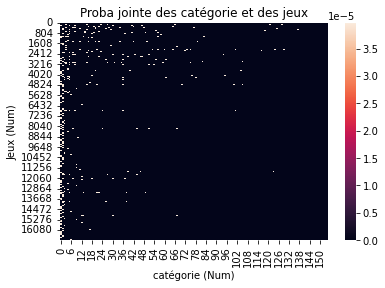

In [28]:
sns.heatmap(p_C_J)
plt.xlabel("catégorie (Num)")
plt.ylabel("Jeux (Num)")
plt.title('Proba jointe des catégorie et des jeux')
plt.show()

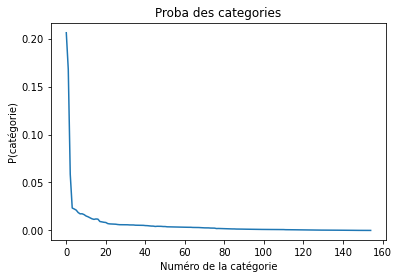

In [29]:
p_cat = p_C_J.sum(axis=0) 
plt.plot(p_cat)
plt.xlabel("Numéro de la catégorie")
plt.ylabel("P(catégorie)")
plt.title("Proba des categories")
plt.show()

**Soit P_CsJ la proba de la catégorie sachant le jeux (liste des categorie des jeux)**

In [30]:
P_CsJ = []
jeux_cat_up_gen.map(lambda l : (np.isin(uc_cats_gen, l).astype(int) / (len(l) if len(l) != 0 else 1)).tolist()).map(P_CsJ.append)
P_CsJ = np.array(P_CsJ)
P_CsJ.shape

(16873, 155)

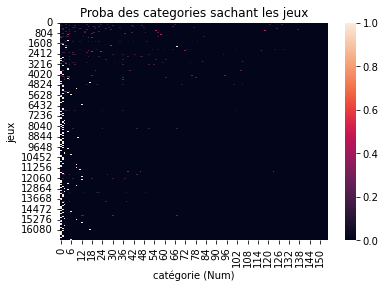

In [31]:
sns.heatmap(P_CsJ)
plt.xlabel("catégorie (Num)")
plt.ylabel("jeux")
plt.title('Proba des categories sachant les jeux')
plt.show()

**Soit Q les fréquences des catégories**

In [32]:
Q = []
jeux_cat_up_gen.map(lambda l : np.isin(uc_cats_gen, l).astype(int).tolist()).map(Q.append)
Q = np.array(Q)
Q = Q.sum(axis=0)

#### Choix d'une catégorie unique pour chaque jeux : 

Comme il existe plusieurs jeux avec plusieurs catégories, une idée pour réduire le nombre de catégories est de choisir qu'une catégorie unique dans l'espoir de supprimer certaines.

La catégorie choisie sera celle qui est maximale pour une certaine mesure

1. **Une mesure d'importance I :**

Soit I une mesure d'importance donné sous cette forme :

$$I(cat_i) = \frac{1}{Q(cat_i)} \times \sum_j P(cat_i | L_j) = \frac{1}{Q(cat_i)} \times \sum_j\frac{E_j(cat_i)}{\lvert L_j \rvert} \ \ avec \ E_j(cat_i) = 1 \ si \ cat_i \in L_j$$

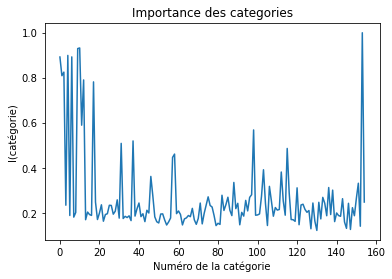

In [33]:
I = P_CsJ.sum(axis=0) / Q
plt.plot(I)
plt.xlabel("Numéro de la catégorie")
plt.ylabel("I(catégorie)")
plt.title("Importance des categories")
plt.show()

In [34]:
jeux_cat_up_I = jeux_cat_up_gen.copy()
l_uc_cats = list(uc_cats_gen)

for j, row in jeux_cat_up_gen.iteritems():
        
    if len(row) == 0:
        continue
        
    I_j = np.zeros(len(l_uc_cats))
    for cat in row:
        i = l_uc_cats.index(cat)
        I_j[i] = I[i]
        
    i_max = np.argmax(I_j)
    jeux_cat_up_I[j] = [l_uc_cats[i_max]]

In [35]:
cats = []
jeux_cat_up_I.map(cats.extend)

one_uc_cats_I, count_cats = np.unique(cats, return_counts=True)

index         = count_cats.argsort()[::-1]
count_cats    = count_cats[index]
one_uc_cats_I = one_uc_cats_I[index]

In [36]:
print("Après selection avec I on a : ")
print(f"\t{len(one_uc_cats_I)} categories différentes")
print(f"\t{(jeux_cat_up_I.map(len) == 0).astype(int).sum()} jeux sans categories")

Après selection avec I on a : 
	109 categories différentes
	2723 jeux sans categories


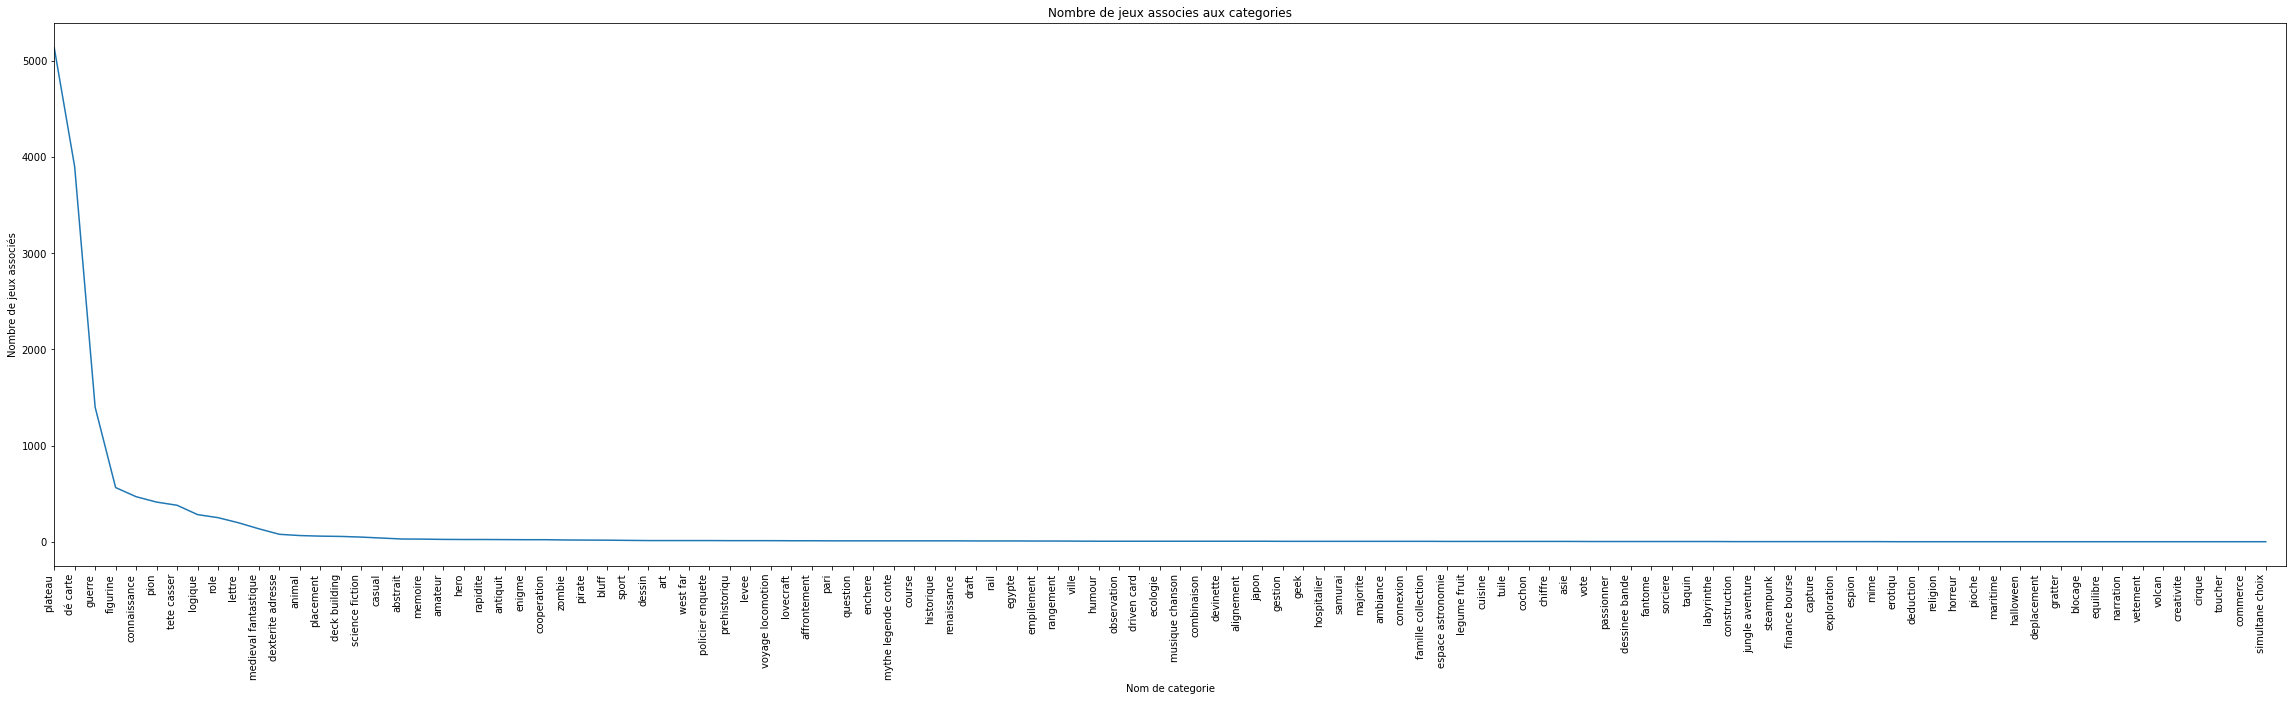

In [37]:
plt.figure(figsize=(40, 10))
plt.plot(one_uc_cats_I, count_cats)
plt.xticks(rotation=90, ha='right')
plt.xlabel("Nom de categorie")
plt.ylabel("Nombre de jeux associés")
plt.title("Nombre de jeux associes aux categories")
plt.xlim((0, len(one_uc_cats_I)))
plt.show()

2. **La fréquence :**



In [38]:
Q

array([5191, 4232, 1476,  589,  564,  535,  471,  436,  438,  416,  380,
        359,  334,  306,  291,  302,  297,  235,  224,  215,  209,  180,
        172,  169,  168,  164,  156,  151,  151,  150,  150,  149,  145,
        144,  144,  138,  137,  136,  136,  134,  128,  126,  121,  115,
        114,  105,  110,  109,  108,  103,  103,   96,   95,   95,   92,
         92,   90,   88,   87,   86,   85,   83,   83,   83,   79,   79,
         79,   77,   74,   72,   68,   68,   67,   63,   62,   61,   50,
         52,   50,   47,   46,   42,   42,   41,   40,   40,   37,   37,
         36,   35,   33,   33,   32,   32,   30,   30,   29,   29,   28,
         27,   27,   26,   26,   25,   25,   24,   24,   24,   24,   24,
         23,   20,   20,   20,   18,   18,   17,   16,   16,   15,   15,
         14,   14,   13,   12,   11,   11,    9,    9,    9,    9,    9,
          8,    8,    7,    7,    7,    6,    6,    6,    6,    5,    5,
          4,    4,    3,    3,    3,    2,    2,   

In [39]:
jeux_cat_up_Q = jeux_cat_up_gen.copy()
l_uc_cats = list(uc_cats_gen)

for j, row in jeux_cat_up_gen.iteritems():
        
    if len(row) == 0:
        continue
        
    Q_j = np.zeros(len(l_uc_cats))
    for cat in row:
        i = l_uc_cats.index(cat)
        Q_j[i] = Q[i]
        
    i_max = np.argmax(Q_j)
    jeux_cat_up_Q[j] = [l_uc_cats[i_max]]

In [40]:
cats = []
jeux_cat_up_Q.map(cats.extend)

one_uc_cats_Q, count_cats = np.unique(cats, return_counts=True)

index         = count_cats.argsort()[::-1]
count_cats    = count_cats[index]
one_uc_cats_Q = one_uc_cats_Q[index]

In [41]:
print("Après selection avec Q on a : ")
print(f"\t{len(one_uc_cats_Q)} categories différentes")
print(f"\t{(jeux_cat_up_Q.map(len) == 0).astype(int).sum()} jeux sans categories")

Après selection avec Q on a : 
	96 categories différentes
	2723 jeux sans categories


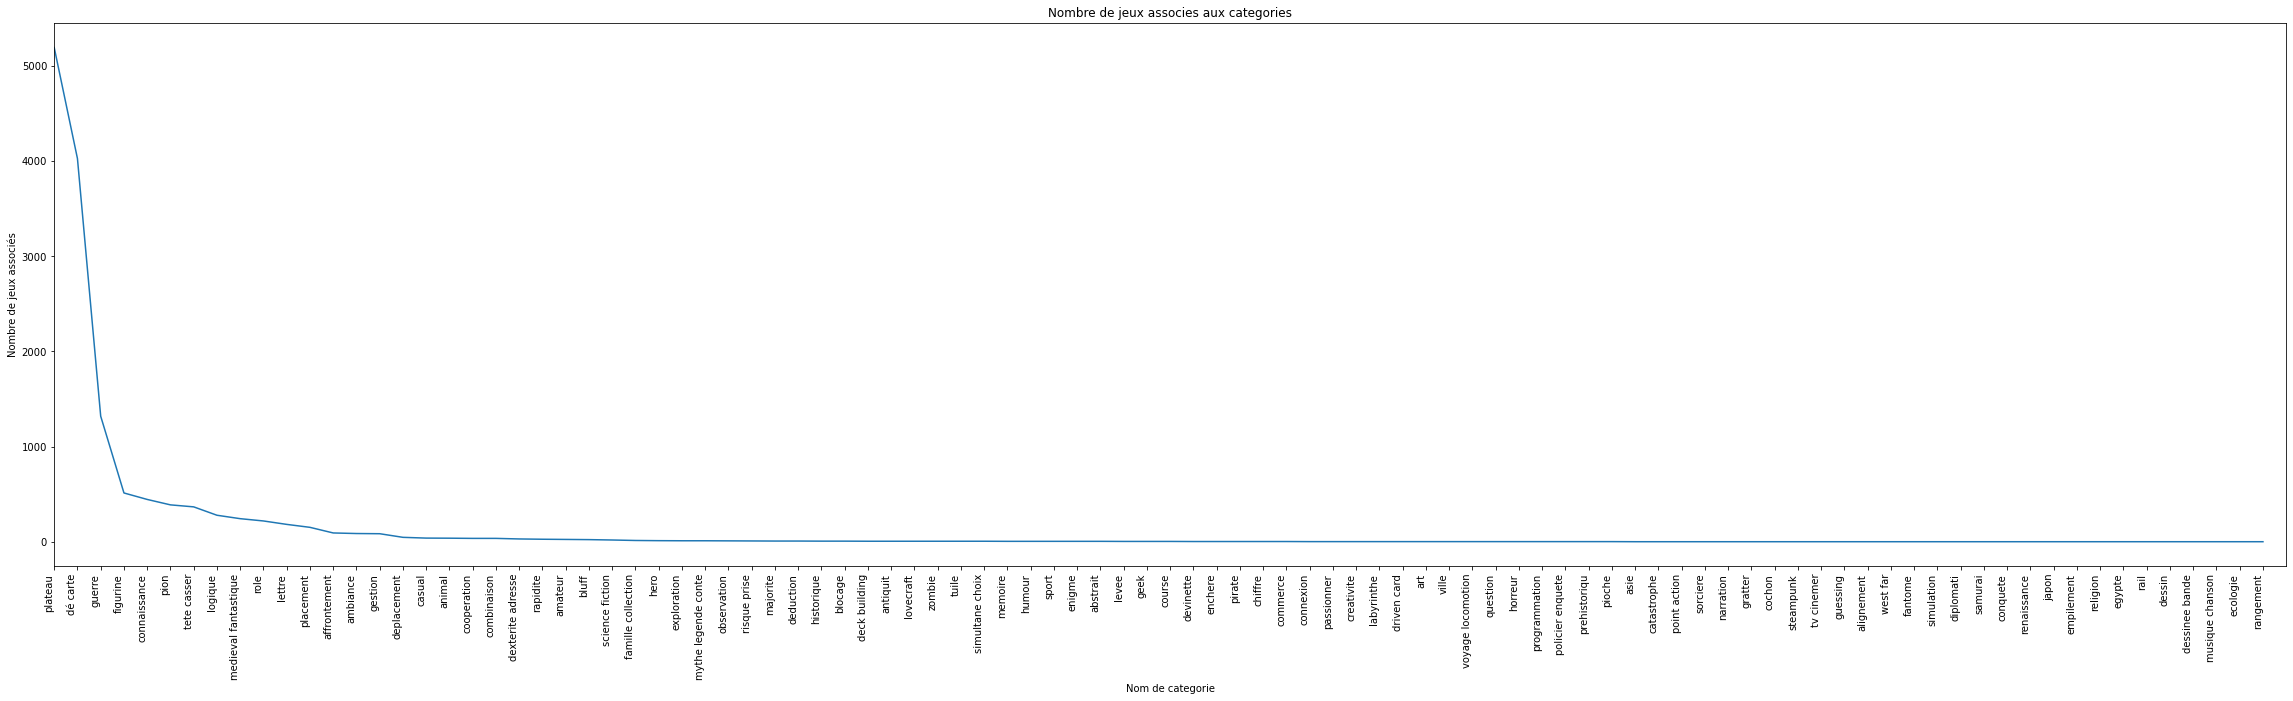

In [42]:
plt.figure(figsize=(40, 10))
plt.plot(one_uc_cats_Q, count_cats)
plt.xticks(rotation=90, ha='right')
plt.xlabel("Nom de categorie")
plt.ylabel("Nombre de jeux associés")
plt.title("Nombre de jeux associes aux categories")
plt.xlim((0, len(one_uc_cats_Q)))
plt.show()

On décide de prendre le résultat de la mesure de fréquence Q

### 4. Seuillage :

On supprime les catégories qui apparaissent moins d'une certaine valeur `cat_lim`

In [43]:
cat_lim = 6

In [44]:
cats = one_uc_cats_Q[count_cats > cat_lim]

print("Catégories résultantes : \n\n", cats)
print("\nNombre de catégories distinctes restantes : ", len(cats))
print("\nNombre de catégories supprimées : ", len(one_uc_cats_Q) - len(cats))

Catégories résultantes : 

 ['plateau' 'dé carte' 'guerre' 'figurine' 'connaissance' 'pion'
 'tete casser' 'logique' 'medieval fantastique' 'role' 'lettre'
 'placement' 'affrontement' 'ambiance' 'gestion' 'deplacement' 'casual'
 'animal' 'cooperation' 'combinaison' 'dexterite adresse' 'rapidite'
 'amateur' 'bluff' 'science fiction' 'famille collection' 'hero'
 'exploration' 'mythe legende conte' 'observation' 'risque prise'
 'majorite' 'deduction' 'historique' 'blocage']

Nombre de catégories distinctes restantes :  35

Nombre de catégories supprimées :  61


In [45]:
jeux_cat_seuil = jeux_cat_up_Q.copy()

jeux_cat_seuil = jeux_cat_seuil.map(lambda l : l[0] if (len(l) != 0 and l[0] in cats) else np.NaN)
jeux_cat_seuil.head()

0          NaN
1          NaN
2    placement
3          NaN
4      gestion
dtype: object

In [46]:
print("\nNombre de jeux avec des catégories : ", jeux_cat_seuil.notna().astype(int).sum())
print("\nNombre de jeux sans catégories : ", jeux_cat_seuil.isna().astype(int).sum())


Nombre de jeux avec des catégories :  14006

Nombre de jeux sans catégories :  2867


In [47]:
cats = []
jeux_cat_seuil.map(cats.append)

cats_seuil, count_cats = np.unique(cats, return_counts=True)

index      = count_cats.argsort()[::-1]
count_cats = count_cats[index]
cats_seuil = cats_seuil[index]

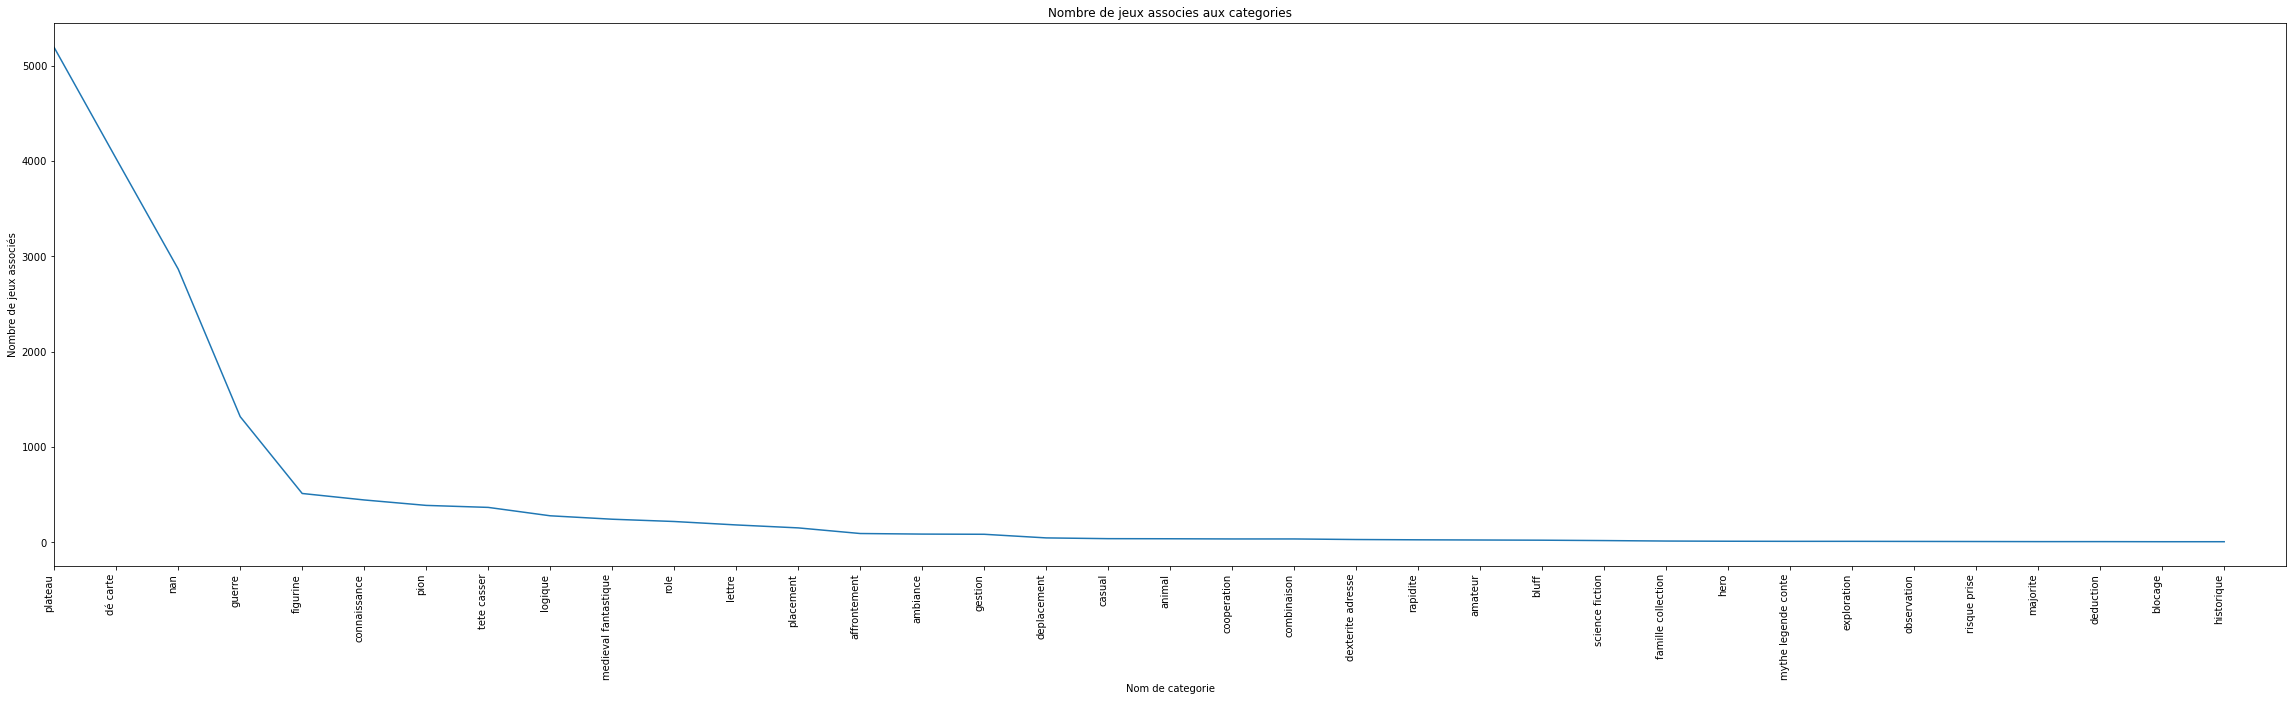

In [48]:
plt.figure(figsize=(40, 10))
plt.plot(cats_seuil, count_cats)
plt.xticks(rotation=90, ha='right')
plt.xlabel("Nom de categorie")
plt.ylabel("Nombre de jeux associés")
plt.title("Nombre de jeux associes aux categories")
plt.xlim((0, len(cats_seuil)))
plt.show()

## III. Sauvegarde du nouveau dataset : 

Mettre à jour le dataset 

In [51]:
df_jeux_up["categories"] = jeux_cat_seuil

In [52]:
df_jeux_up.head()

,Nombre d'avis,full_title,Note rectifiée,Note,Note Finkel,categories,Nombre d'avis rectifiés,description,titre,_id,...,editors,distributors,nb_players,age_required,duration,enfant,ado,adulte,solo,multi
0,19.0,Marvel United (2020),8.40,7.58,8.74,NaN,10.0,\n Marvel United : Unis c...,Marvel United,marvel-united,...,CMON Limited,NaN,1-4,14-99,45.0,0,1,1,1,1
1,33.0,Mariposas (2020),7.29,7.39,7.68,NaN,17.0,"\n Chaque année, au print...",Mariposas,mariposas,...,Gigamic,NaN,2-5,14-99,60.0,0,1,1,0,1
2,28.0,Quetzal (2020),7.22,8.18,7.42,placement,9.0,\n Vous êtes à la tête d’...,Quetzal,quetzal,...,Gigamic,NaN,2-5,8-99,45.0,0,1,1,0,1
3,4.0,Alien - Kit de Démarrage (2020),0.00,9.00,0.00,NaN,0.0,\n Un Kit de démarrage co...,Alien - Kit de Démarrage,alien-kit-de-demarrage,...,Arkhane Asylum Publishing,NaN,1-99,12-99,NaN,0,1,1,1,1
4,72.0,The LOOP (2020),8.79,8.75,9.70,gestion,24.0,\n Le Dr Foo a créé une t...,The LOOP,the-loop,...,Catch Up Games,NaN,1-4,12-99,60.0,0,1,1,1,1


In [53]:
df_jeux_up.to_csv('../data/details_categ.csv', index=False)